# INFO 103: Introduction to data science <br> Demo \#3: APIs<br> Author: JRW
## Mission
In this work book we're going to take a look at how APIs really work from a programming point of view to gain insight into how they are used to build online applications. 

1. Build our own API client for the Facebook Graph API to:
    - download user posts,
    - extract posted images, and
    - gather a stream of user comments.
2. Use a well-developed Twitter API client to:
    - download historical (famous) tweets by ID,
    - download a specific twitter users recent timeline of tweets, and
    - filter a live stream of tweets by key words and locations.
3. Use a well-developed Google API client to:
    - find geographic information from a street address,
    - find a street address from a latitude/longitude pair, and
    - find directions between two places by name.

In [29]:
import json
import os, re
import urllib.request
from IPython.core.display import display
from PIL import Image
from StringIO import StringIO

## Quotas
Remember, APIs are not usually free. They will just about always come with a liscence and the way most of the sites enforce a paywall is with a rate limit or quota. 

#### Graph API limits
Facebook's is so hard to hit that you may never notice (1 query/second), but they reserve the much more massive trove of private data they have. 

#### Twitter API limits
Twitter will let you see pretty much any of their data, but cap you at a 1% stream limit, or at 180 calls per 15 minute window if you are using the rest API.

#### Geocoding quotas
Users of the standard API:

2,500 free requests per day, calculated as the sum of client-side and server-side queries.
50 requests per second, calculated as the sum of client-side and server-side queries.

#### Directions quotas
Users of the standard API:

2,500 free directions requests per day, calculated as the sum of client-side and server-side queries.
Up to 23 waypoints allowed in each request, whether client-side or server-side queries.
50 requests per second, calculated as the sum of client-side and server-side queries.

## Facebook
#### What is the Facebook Graph API
Data from Facebook comes from the 'Graph' API, because that view their platform as a network, or, 'graph'. The documentation for this API may be found at:

* https://developers.facebook.com/docs/graph-api

The graph API allows you to access information about specific individuals, friends, and posts, etc. Anyone with a Facebook account can access the Graph API, and there are other APIs, such as the Public Feed API:

* https://developers.facebook.com/docs/public_feed/

which provides streaming data, i.e., live emerging data. However, this API is really only available to a restricted set of users, so we will focus only on the Graph API. 

#### Getting a Facebook app ID

As mentioned, you can use the Graph API if you are on Facebook, but to do this you have to register as a developer. As usual, there are some helpful resources out there on stackoverflow:

* http://stackoverflow.com/questions/3203649/where-can-i-find-my-facebook-application-id-and-secret-key

Here, I would say that the most helpful suggestion directs to the app registration page. Create an app:

* https://developers.facebook.com/apps

After you create an app, you will wind up on the app's development page. At the top of this page is your App ID. Record your ID in the string here:

In [2]:
APP_ID = ""

You will also need to get you App's secret code. This may be obtained by navigating to "settings" in the navigation on the left side of the app development. Once there, you will have to click on the "show" button to see the secret code. Record this string here:

In [3]:
APP_SECRET = ""

#### Building API requests as URL strings
Api requests on both of Facebook and twitter are really just URLs. This makes sense, because whenever you look at a webpage you are actually just downloading its content. There are a lot of details on the Facebook Graph API, and we're just going to build one kind of request: the last $N$ public posts of a particular user. The following function creates a request URL from several inputs, notably the user's name (username) and the number of past messages to collect (limit). The `APP_ID` and `APP_Secret` are both passed to this function, as well.

In [4]:
def createPostUrl(username, APP_ID, APP_SECRET, limit):
    post_args = "/feed?access_token=" + APP_ID + "|" + APP_SECRET + \
    "&fields=attachments,created_time,message&limit=" + str(limit)
    post_url = "https://graph.facebook.com/" + username + post_args
    return post_url

#### Requesting the data behind a URL
This is the function that really does all of the work, relying on the globally-assigned `APP_ID` and `APP_SECRET`. This function runs the `CreatePostUrl()` function and then makes the http request with the `urllib.request.urlopen()` function. The web response is read, and appears as a string, which, in JSON format is converted to a python dictionary using the `json.loads()` function.

In [5]:
def getPosts(username, limit):
    post_url = createPostUrl(username, APP_ID, APP_SECRET, limit)
    web_response = urllib.request.urlopen(post_url)
    readable_page = web_response.read()
    return json.loads(readable_page)

#### Running the API function
Let's try this out and grab the last 10 posts made by Drexel university (`'drexeluniv'`).

In [6]:
data = getPosts("drexeluniv", 10)

#### Inspecting the output
The resulting data object is a dictionary at the top level with two keys, `'paging'`, and `'data'`. The value of `'data'` is what we're really looking for, and `'paging'` is actually another post URL that helps us to go even further back in time. In other words, we only asked for the 10 most recent posts, and if we want the ten before those, we just use the URL in `data['paging']`. Check it out:

In [7]:
data['paging']

{u'next': u'https://graph.facebook.com/v2.8/186291828074120/feed?fields=attachments,created_time,message&limit=10&access_token=1208710585909417|f39c72a53e7813c6e01e683f51435a76&until=1491569557&__paging_token=enc_AdDlIkBTUgHZCcwdib3ez9mwvTZB9rjE9gVZCu4AYwqFMOn0ka1Cod4s2Y7ZCoiyPXuvVOlcvZATZCsl7uB4UX5L5KO5mmXu0ZAYHfL8UQBunpvzcZCZAUgZDZD',
 u'previous': u'https://graph.facebook.com/v2.8/186291828074120/feed?fields=attachments,created_time,message&limit=10&since=1492610474&access_token=1208710585909417|f39c72a53e7813c6e01e683f51435a76&__paging_token=enc_AdDiKs7BFWttXxJD7HOMBULdE9UHawa9jD8wYcaT3YExFbDjCGpMb3ZChDTF7HVAx94OtRGa2Dk3mIHFtZChtqyaMlSin5mcBB8VN7RnNzT8nJ6wZDZD&__previous=1'}

#### The actual data
That's ugly, but it's really important if we want to way back in time and great that we don't have to build it. The actualy data it self is under the `'data'` key, and is a list of the different posts. Let's look at the first (most recent) post:

In [8]:
data['data'][0]

{u'attachments': {u'data': [{u'description': u'Join us for a block party celebrating #EarthDay! Food, games and giveaways start at 11 a.m. at Lancaster Walk. http://drexe.lu/1YEUWh1',
    u'media': {u'image': {u'height': 280,
      u'src': u'https://scontent.xx.fbcdn.net/v/t1.0-9/18033271_1291454200891205_129141523262089011_n.jpg?oh=fd9d121105da7a35efa27dda05328875&oe=59969101',
      u'width': 570}},
    u'target': {u'id': u'1291454200891205',
     u'url': u'https://www.facebook.com/drexeluniv/photos/a.193057994064170.35892.186291828074120/1291454200891205/?type=3'},
    u'title': u'Timeline Photos',
    u'type': u'photo',
    u'url': u'https://www.facebook.com/drexeluniv/photos/a.193057994064170.35892.186291828074120/1291454200891205/?type=3'}]},
 u'created_time': u'2017-04-19T14:01:14+0000',
 u'id': u'186291828074120_1291454200891205',
 u'message': u'Join us for a block party celebrating #EarthDay! Food, games and giveaways start at 11 a.m. at Lancaster Walk. http://drexe.lu/1YEUWh1

#### What are the individual pieces of data we requested?
In addition to the post message, the URL requests we built include any attachments and the creation time. The creation time `'created_time'` is fairly straightforward, but the attachments include any images that were in the post. Here's the primary message, itself:

In [9]:
data['data'][0]['message']

u'Join us for a block party celebrating #EarthDay! Food, games and giveaways start at 11 a.m. at Lancaster Walk. http://drexe.lu/1YEUWh1'

#### What if we want to see the photo?
The attachments key has another dictionary as value, let's take a look:

In [10]:
data['data'][0]['attachments']

{u'data': [{u'description': u'Join us for a block party celebrating #EarthDay! Food, games and giveaways start at 11 a.m. at Lancaster Walk. http://drexe.lu/1YEUWh1',
   u'media': {u'image': {u'height': 280,
     u'src': u'https://scontent.xx.fbcdn.net/v/t1.0-9/18033271_1291454200891205_129141523262089011_n.jpg?oh=fd9d121105da7a35efa27dda05328875&oe=59969101',
     u'width': 570}},
   u'target': {u'id': u'1291454200891205',
    u'url': u'https://www.facebook.com/drexeluniv/photos/a.193057994064170.35892.186291828074120/1291454200891205/?type=3'},
   u'title': u'Timeline Photos',
   u'type': u'photo',
   u'url': u'https://www.facebook.com/drexeluniv/photos/a.193057994064170.35892.186291828074120/1291454200891205/?type=3'}]}

This dictionary holds another dictionary with only one key, `'data'`, whose value is a list containing all of the meat. It's a list because the post may have multiple attachments! There's only one here, and it has a `'description'` and `'title'`, a `'url'` to the linked Drexel website and not the actual image. To get the actual image, we need to look at the `'media'` key under `'image'` and then `'src'`. Follow this link with your browser and you'll see the image that Drexel posted, which is of Berlin.

In [11]:
data['data'][0]['attachments']['data'][0]['media']['image']['src']

u'https://scontent.xx.fbcdn.net/v/t1.0-9/18033271_1291454200891205_129141523262089011_n.jpg?oh=fd9d121105da7a35efa27dda05328875&oe=59969101'

#### What if we want to download the image?
Well, technically navigating to the above URL does download the image, but if you want it saved on your computer, or in your Python workspace, you can once again use the `urllib.request.urlopen()` function. The image data that is downloaded is just a string, and can be written out to file like text or anything else. It's a really big string, so dont try and print it. Instead, we should convert the string to a Python image with `Image()`, and use the IPython `display()` function:

In [12]:
web_response = urllib.request.urlopen(data['data'][0]['attachments']['data'][0]['media']['image']['src'])
image_data = web_response.read()
image_object = Image.open(StringIO(image_data))

Running this will open the image in a window.

In [13]:
image_object.show()

And running this will place the display right here in the notebook

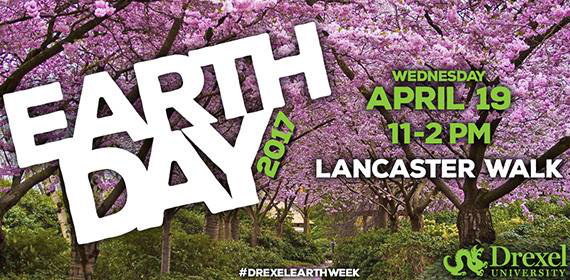

In [14]:
display(image_object)

## APIs usually handle many types of request
So far we have set up to be able to gather a stream of pubic posts going back in time. As organizations (like Drexel) post public updates Facebook users will often comment, generating threaded discussion. Since these discussions are also public, we can access them. Let's look at one pose back so some comments will have had the chance to accumulate.

Join us for a block party celebrating #EarthDay! Food, games and giveaways start at 11 a.m. at Lancaster Walk. http://drexe.lu/1YEUWh1


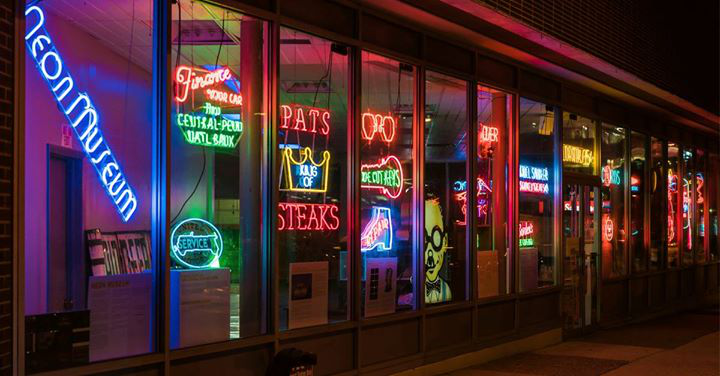

In [16]:
web_response = urllib.request.urlopen(data['data'][1]['attachments']['data'][0]['media']['image']['src'])
image_data = web_response.read()
image_object = Image.open(StringIO(image_data))
print(data['data'][0]['message'])
display(image_object)

Hey, this is about that neon sign museaum!

#### Facebook objects have unique identifiers
To be able to request to comments associated to a post we will have to be able to provide the unique identifier for a post. Fortunately, this is provided!

In [20]:
print(data['data'][1]['id'])

186291828074120_1290424327660859


#### Creating separate URL and request functions for comments
Sadly, our first API-access function won't do for this type of request. Instead we will have to include a place for post IDs and specifically build a comments query. Note that there is also the 'filter' option for the comments, which ensures that all comments are returned in chronological order. 

In [18]:
def createPostCommentsUrl(POST_ID, APP_ID, APP_SECRET, limit):
    comments_args = "/comments?access_token=" + APP_ID + "|" + APP_SECRET + \
    "&filter=stream&limit=" + str(limit)
    post_url = "https://graph.facebook.com/" + POST_ID + comments_args
    return post_url

In [23]:
def getPostComments(POST_ID, limit):
    comments_url = createPostCommentsUrl(POST_ID, APP_ID, APP_SECRET, limit)
    web_response = urllib.request.urlopen(comments_url)
    readable_page = web_response.read()
    return json.loads(readable_page)

#### Requesting comments
Here, we will request the comments from the second to last post made by Drexel. Once again, there is paging information and the data. Once again, since we've requested multiple comments we have a list as a return object. Let's loop through the comments and print them out along with their `'created_time'`.

In [28]:
comments_data = getPostComments(data['data'][1]['id'], 10)
print("This post currently has "+str(len(comments_data['data']))+" comments. Here's what we got:\n")
for comment in comments_data['data']:
    print(comment["created_time"])
    print(comment["message"])
    print("")

This post currently has 10 comments. Here's what we got:

2017-04-18T16:19:00+0000
Didn't Drexel kick Firestone out to expand? So students no longer have a reputable local repair shop for their vehicles...

2017-04-18T16:36:01+0000
They were far overpriced, had terrible service and there are a ton in the city that are easy enough to get to.  It's no loss.

2017-04-18T16:48:04+0000
Chris Chiriaco Detris this is what we saw

2017-04-18T17:54:00+0000
That place was such an eye sore.

2017-04-18T17:54:17+0000
Oh yea!!

2017-04-18T19:33:31+0000
I think the windows might need a good cleaning.  At least in the daylight they look pretty foggy.

2017-04-18T19:57:24+0000
Mark Giovinazzi

2017-04-18T22:51:30+0000
Kelli Kushner...so cool

2017-04-18T23:01:23+0000
I am sure that it will receive glowing reviews.

2017-04-18T23:35:42+0000
Michael, somewhat interesting setup I walk by every night on my way home from classes



#### The data emerge oldest to newest
Note that all of these comments are from a few days ago and are getting newer. This is the reverse order of the posts feed, where we have to go back in time! Also, it appears people were more immediately interested with the move of firestone. My favorite comment is the 'glowing reviews' comment for the museaum...

## Twitter 
What if we want data from another source? Twitter has a similar API and actually makes much more of its data available than Facebook. However, it doesn't always have to be so difficult as constructing your very own API request URLs. In fact, python has several clients (modules) for downloading data from twitter that make the API access very easy! Here, we'll use `tweepy`. Since this is just a client, be aware that it may have limited functionality. So if you want to see everything that the API can do, check out the full documentation. However, like we were doing with the Facebook API, this may require building your own URLs.

* https://dev.twitter.com/docs

Just like with facebook, you'll have to get API access keys, which (from [stackoverflow](http://stackoverflow.com/questions/1808855/getting-new-twitter-api-consumer-and-secret-keys)) involves:

1. Having a twitter account
2. Go to https://apps.twitter.com and sign in.
3. Create an app (fill out the form).
4. Go To API keys section and click generate ACCESS TOKEN.

Note that the resulting keys are refferred to as:

* 'oauth_access_token' means **Access token**
* 'oauth_access_token_secret' means **Access token secret**
* 'consumer_key' means **API key**
* 'consumer_secret' **means API secret**


To get `tweepy`, just go to a command line and enter:

```
pip install tweepy
```

tweepy is pretty well documented, too:

* http://docs.tweepy.org/en/v3.5.0/index.html
* https://github.com/tweepy/tweepy


#### Getting started
First things first, we will need to import the necessary modules and enter our access keys.

In [30]:
import tweepy
import json

consumer_key=""
consumer_secret=""
access_token=""
access_token_secret=""

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

#### The rest API
The rest API allows you to access historical data (i.e., data that is 'resting') and to manage your account. This means looking up tweets by ID, and also follow/unfollow other accounts, etcetera. With tweepy, we first have to initialize a rest api instance.

In [31]:
rest = tweepy.API(auth)

#### Downloading some old tweets
To get some old tweets we will need a list of tweet IDs. Let's see if we can get the tweets from this list:

* https://www.buzzfeed.com/danieldalton/epic-tweet-bro?utm_term=.ol3l3ZjAq#.pk8ke2VgN

Note: gathering the list of tweet IDs required going into the source html. After next week, we could write a web scraper to pull this out for us!

In [41]:
idlist = [
    "1121915133", 
    "64780730286358528", 
    "64877790624886784", 
    "20", 
    "467192528878329856", 
    "474971393852182528",
    "475071400466972672",
    "475121451511844864",
    "440322224407314432",
    "266031293945503744",
    "3109544383",
    "1895942068",
    "839088619",
    "8062317551",
    "232348380431544320",
    "286910551899127808",
    "286948264236945408",
    "27418932143",
    "786571964",
    "467896522714017792",
    "290892494152028160",
    "470571408896962560"
]
data = {id_: "" for id_ in idlist}
tweets = rest.statuses_lookup(id_=idlist, include_entities=True)

#### What does a tweet look like?
The resulting status objects have a lot of extra structure to them, but a python dictionary of Twitter's raw format may be accessed through the `._json` value of the object. Let's look at the keys.

In [40]:
print(tweets[0]._json.keys())

[u'contributors', u'truncated', u'text', u'is_quote_status', u'in_reply_to_status_id', u'id', u'favorite_count', u'source', u'retweeted', u'coordinates', u'entities', u'in_reply_to_screen_name', u'in_reply_to_user_id', u'retweet_count', u'id_str', u'favorited', u'user', u'geo', u'in_reply_to_user_id_str', u'lang', u'created_at', u'in_reply_to_status_id_str', u'place']


The most important thing here is the `'text'`, but there's lots of other good stuff too. Let's look at all 19 of the tweets in order. Unfortunately, since the order is off, we will have to fix it.

In [50]:
for tweet in tweets:
    data[str(tweet._json['id'])] = tweet._json
for ix, id_ in enumerate(idlist):
    print(str(ix+1)+": "+data[id_]['text'])

1: http://twitpic.com/135xa - There's a plane in the Hudson. I'm on the ferry going to pick up the people. Crazy.
2: Helicopter hovering above Abbottabad at 1AM (is a rare event).
3: So I'm told by a reputable person they have killed Osama Bin Laden. Hot damn.
4: just setting up my twttr
5: India has won! भारत की विजय। अच्छे दिन आने वाले हैं।
6: We can neither confirm nor deny that this is our first tweet.
7: Thank you for the @Twitter welcome! We look forward to sharing great #unclassified content with you.
8: @CIA We look forward to sharing great classified info about you http://t.co/QcdVxJfU4X https://t.co/kcEwpcitHo More: https://t.co/PEeUpPAt7F
9: If only Bradley's arm was longer. Best photo ever. #oscars http://t.co/C9U5NOtGap
10: Four more years. http://t.co/bAJE6Vom
11: Facebook turned me down. It was a great opportunity to connect with some fantastic people. Looking forward to life's next adventure.
12: Got denied by Twitter HQ. That's ok. Would have been a long commute.
13: A

#### Getting a user's timeline
Now, we can also follow a specific user easily with tweepy. Let's get the last 10 tweets from Drexel (`drexeluniv`).

In [52]:
timeline = rest.user_timeline(screen_name = "drexeluniv", count = 10)
for tweet in timeline:
    print(tweet._json["text"])

RT @wordsbyholli: Wonderful day for some #yoga at #DrexelEarthWeek at @DrexelUniv with @MAbramsKYW @KYWNewsradio https://t.co/IAsddN5RRJ
RT @wordsbyholli: #DrexelEarthWeek happening now at @DrexelUniv #Earthday @MAbramsKYW @KYWNewsradio https://t.co/XqLIcHFBYf
Join us for a block party celebrating #EarthDay! Food, games and giveaways start at 11 a.m. at Lancaster Walk.… https://t.co/ldVHS04tjk
Instagram contest: Show us what sustainability means to you? Tag your photos #DrexelEarthWeek for a chance to win. https://t.co/hiSUE941h8
RT @DrexelNow: The Philly Science Festival is coming up soon! Here's how @AcadNatSci is getting involved: https://t.co/hZqTkOHvH5 https://t…
Vintage neon signs and art pieces that once belonged to #Philly businesses are back on display on #Drexel’s campus:… https://t.co/bvxDKvG64A
A record-breaking eight #Drexel students and alumni received @FulbrightPrgrm grants this year.… https://t.co/16VWVE7zPg
Catch Drexel's @Witnesses_Natl testing for lead in their homes

#### The streaming API
So far we've only accessed the rest API for old tweets. Twitter is neat because it also makes its streaming API available to the public (at 1% bandwidth). Here's some mode advanced tweepy code that allows us to download `N` immediately recent tweets from the stream using keyword and geolocation filters.

In [53]:
class StdOutListener(tweepy.streaming.StreamListener):
    """ A listener handles tweets that are received from the stream.
    This listener collects N tweets, storing them in memory, and then stops.
    """
    def __init__(self, N):
        super(StdOutListener,self).__init__(self)
        self.data = []
        self.N = N
    def on_data(self, data):
        self.data.append(json.loads(data))
        if len(self.data) >= self.N:
            return False
        else:
            return True

    def on_error(self, status):
        print(status)

In [58]:
def getNtweets(N, auth, track = [], locations = []):
    listener = StdOutListener(N)
    stream = tweepy.Stream(auth, listener)
    if len(track) and len(locations):
        stream.filter(track=track, locations = locations)
    elif len(track):
        stream.filter(track = track)
    elif len(locations):
        stream.filter(locations = locations)

    return listener.data

In [59]:
dataScienceTweets = getNtweets(10, auth, track=['data', 'science'])
for tweet in dataScienceTweets:
    print(tweet['text'])

Data Visualization “Versus” UI and Data Science – Lynn Cherny – Medium https://t.co/8NDq26ep1x https://t.co/hs791PgYFS
RT @TonyZador: Immigrants: Keeping American Science Great! https://t.co/lApFMoh5tr
...but Witko was so laid-back that I had to match his style and, I've been awful at science fair projects since 3rd grade 🤷🏾‍♂️
@Perdnoot @RCarrier_Errors @Lead1225 @historyguytn @ellen5e in those fields, or who are but have an agenda having n… https://t.co/WRLet5yqLG
I AM SO EXCITED ABOUT RESEARCH AND SCIENCE AND THE RIDICULOUSLY COOL OPPORTUNITIES MY EDUCATION PROVIDES ME.
Nicht vergessen, morgen ist Science March, Freunde!
Wir sehen uns 13:30 am Theaterplatz!
https://t.co/KsRvVJZt6r
RT @FarazRabbani: A Wondrous New Image of Planet Earth - The Atlantic https://t.co/Kjofq023XR
April 22: Earth Day and the Science March! I am unable to attend local events due to a wedding… https://t.co/I0ZoMLPSoD
How Elon Musk and Neuralink aim to meld minds and machines https://t.co/bZhacFZYYT
RT @BTS_Bo

#### Geolocation data
As mentioned above, we can also use the streaming API to filter data by location. Let's look at 10 recent tweets from Philadelphia! To do this, we will have to get a lat/lon bounding box for philadelphia. I got these number from

* https://github.com/amyxzhang/boundingbox-cities/blob/master/boundbox.txt

but as we will see below, we could gather this data from Google's API. Note: the lat/lon order for a location box is `[lon1,lat1,lon2,lat2]`. Note that because there are fewer tweets coming from such a small box, this will take a bit longer to run for 10 the tweets!

In [ ]:
bbox = [-75.280327, 39.864841, -74.941788, 40.154541]
phillyTweets = getNtweets(10, auth, locations=bbox)

In [61]:
phillyTweets[0].keys()

[u'contributors',
 u'truncated',
 u'text',
 u'is_quote_status',
 u'in_reply_to_status_id',
 u'id',
 u'favorite_count',
 u'source',
 u'retweeted',
 u'coordinates',
 u'timestamp_ms',
 u'entities',
 u'in_reply_to_screen_name',
 u'id_str',
 u'display_text_range',
 u'retweet_count',
 u'in_reply_to_user_id',
 u'favorited',
 u'user',
 u'geo',
 u'in_reply_to_user_id_str',
 u'lang',
 u'created_at',
 u'filter_level',
 u'in_reply_to_status_id_str',
 u'place']

In [65]:
for tweet in phillyTweets:
    print(tweet['place']['full_name'])
    print(tweet['text'])
    print("")

New Jersey, USA
@cdbarker I can't imagine how hard it must be to make up 5 days of testing.

Philadelphia, PA
I'm very upset with the decision by @Microsoft to kill @Wunderlist, very upset.

New Jersey, USA
We have 5 classic vintage and antique train set auctions running now 😄 Great Memories Make Great 🎁

Pennsylvania, USA
@hermitdave @1ShotApp @AA_WP Looks sweet I will use it on my 650 when it shows up tomorrow

Philadelphia, PA
#EastFalls #Philadelphia #April2017 #SpringAwaken2017 #PurpleFlowers #InBloom #bonnelefluere… https://t.co/DTXfwBUuxB

Springdale, NJ
@Statiqul @mikeangeli88 @undisputed @RealSkipBayless *forgets that they signed Brandon marshall*

Philadelphia, PA
My gf's dad knows my fav candy is 100 Grand bars so he sent us 10 of them and said"that's a million dollars and you're worth every penny."

Pennsylvania, USA
@cinnamontits13 It was a great story. Kid from the streets loses his dad when he was 15. Get a full ride plays for… https://t.co/zUvcosLLTD

Philadelphia, PA
w

## Google
Google has API's for lot's of stuff. This includes all of the geographic features of maps, the linguistic features of translate, and even YouTube data, since Google bought them in 2006 for \$1.65 billion. Here, we're just going to go forward and use a client that provides the geographic services. Like usual, you will have to have a Google account for this. The steps are then:

1. Get a Google account.
2. Get an API key: https://developers.google.com/places/web-service/get-api-key
3. Go to the developer's console https://developers.google.com/console
4. Enable the specific APIs of interest: https://support.google.com/cloud/answer/6158841?hl=en

#### The python client
Here, we're going to use a nice Python client for the maps services called googlemaps. We can install this easily from the command line with pip, once again:

```
pip install -U googlemaps
```

For more information, be sure to check out their project documentation:

* https://github.com/googlemaps/google-maps-services-python


#### Load the client and set up your API instance

In [66]:
import googlemaps
from datetime import datetime

GOOGLE_API_KEY = ""

gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

#### Get the geocoding for Rush and City halls

In [72]:
rushHall = gmaps.geocode('30 N. 33rd Street, Philadelphia, PA')
print(rushHall)

[{u'geometry': {u'location': {u'lat': 39.95681, u'lng': -75.18959}, u'viewport': {u'northeast': {u'lat': 39.95815898029149, u'lng': -75.1882410197085}, u'southwest': {u'lat': 39.95546101970849, u'lng': -75.1909389802915}}, u'location_type': u'ROOFTOP'}, u'address_components': [{u'long_name': u'30', u'types': [u'street_number'], u'short_name': u'30'}, {u'long_name': u'North 33rd Street', u'types': [u'route'], u'short_name': u'N 33rd St'}, {u'long_name': u'University City', u'types': [u'neighborhood', u'political'], u'short_name': u'University City'}, {u'long_name': u'Philadelphia', u'types': [u'locality', u'political'], u'short_name': u'Philadelphia'}, {u'long_name': u'Philadelphia County', u'types': [u'administrative_area_level_2', u'political'], u'short_name': u'Philadelphia County'}, {u'long_name': u'Pennsylvania', u'types': [u'administrative_area_level_1', u'political'], u'short_name': u'PA'}, {u'long_name': u'United States', u'types': [u'country', u'political'], u'short_name': u'US

#### A bounding box for Rush hall!
There's lots of information here about the building, but relating back to our Twitter API experiment, notice how we can actually get a bounding box for the building&mdash;this means we could download all of the tweets appearing from this building!

In [73]:
print(rushHall[0]['geometry']['viewport'])

{u'northeast': {u'lat': 39.95815898029149, u'lng': -75.1882410197085}, u'southwest': {u'lat': 39.95546101970849, u'lng': -75.1909389802915}}


#### Reverse lookup
Note that we can also get the address of a location by lat/lon lookup! Let's see if we can pull the Rush hall address back out of the API.

In [77]:
# Look up an address with reverse geocoding
lat = rushHall[0]['geometry']['location']['lat']
lng = rushHall[0]['geometry']['location']['lng']
reverseLookup = gmaps.reverse_geocode((lat, lng))
for component in reverseLookup[0]['address_components']:
    print(component['long_name'])

30
North 33rd Street
University City
Philadelphia
Philadelphia County
Pennsylvania
United States
19104


#### Directions to city hall
Google is great for driving directions and we can use the API for this, too!

In [90]:
cityHall = gmaps.geocode('1401 John F Kennedy Blvd, Philadelphia, PA')

# Request walking directions
now = datetime.now()
directions_result = gmaps.directions(
    "30 N. 33rd Street, Philadelphia, PA",
    "Philadelphia City Hall",
    mode="walking",
    departure_time=now
)
print(directions_result[0].keys())

[u'overview_polyline', u'warnings', u'bounds', u'waypoint_order', u'summary', u'copyrights', u'legs']


#### What's the result?
Once again, there's a lot of information here. Besides a list of lat/lon pairs for the directions (so you can make a map) there is also a text list of html directions in under the `'legs'` key.

In [95]:
print("It's a "+directions_result[0]['legs'][0]['distance']['text']+" walk, total:\n")
stepnum = 1
for step in directions_result[0]['legs'][0]['steps']:
    print(str(stepnum)+") "+re.sub("<\/?b>", "", step['html_instructions']))
    stepnum += 1

It's a 1.4 mi walk, total:

1) Head south on N 33rd St toward Lancaster Walk
2) Turn left toward Market St
3) Turn right toward Market St
4) Turn left onto Market St
5) Turn left onto N 15th St
